For this task we will use neural style transfer as an optimization technique used to take two images—a content image and a style reference image and blend them together so the output image looks like the content image, but “painted” in the style of the style reference image.

In [1]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

# 1. Import libraries

In [2]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [3]:
def tensor_to_image1(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [4]:
def tensor_to_image2(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

# 2. Download and definte the content and style images

Will have two content and style images to transform.

In [5]:
content_path1 = tf.keras.utils.get_file('administration-buildings.jpg', 'https://www.csueastbay.edu/about/files/images/photo-gallery/administration-buildings.jpg')
content_path2 = tf.keras.utils.get_file('vbt.jpg', 'https://www.csueastbay.edu/universitycommunications/files/images/campus-photo-gallery/vbt.jpg')
style_path1 = tf.keras.utils.get_file('31_crop.png','http://www.kokuyocamlin.com/blog/wp-content/uploads/2018/04/31_crop.png')
style_path2 = tf.keras.utils.get_file('35.jpg','http://http://www.kokuyocamlin.com/blog/wp-content/uploads/2018/04/35.jpg')

In [6]:
pip install keras==2.6.*

Note: you may need to restart the kernel to use updated packages.


# Visualize the input

Define a function to load an image and limit its maximum dimension to 512 pixels.

In [7]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

# Display the images

In [8]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image1 = tf.squeeze(image, axis=0)

  plt.imshow(image1)
  if title:
    plt.title(title)

In [9]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image2 = tf.squeeze(image, axis=0)

  plt.imshow(image2)
  if title:
    plt.title(title)

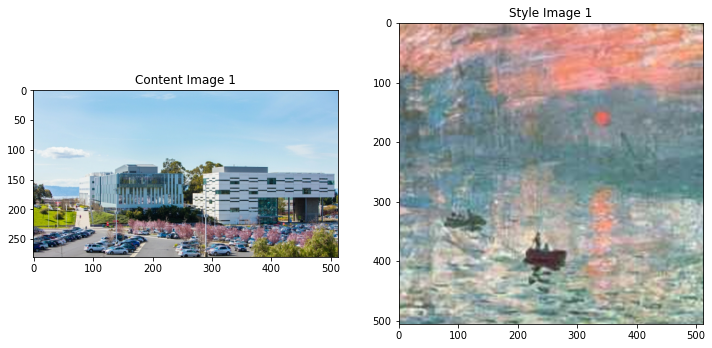

In [10]:
content_image1 = load_img('C:/Users/STSC/Downloads/administration-buildings.jpg')
style_image1 = load_img('C:/Users/STSC/Downloads/31_crop.png')


plt.subplot(1, 2, 1)
imshow(content_image1, 'Content Image 1')

plt.subplot(1, 2, 2)
imshow(style_image1, 'Style Image 1')

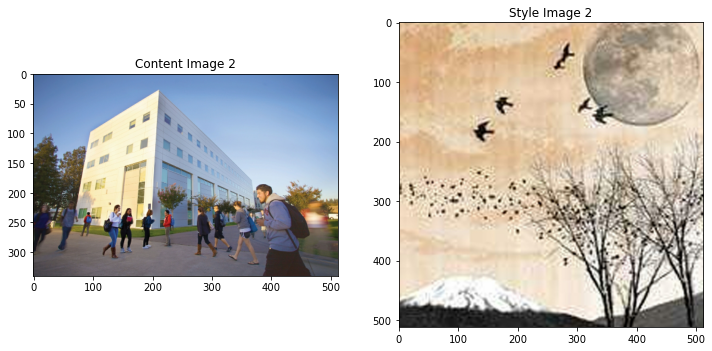

In [11]:
content_image2 = load_img('C:/Users/STSC/Downloads/vbt.jpg')
style_image2 = load_img('C:/Users/STSC/Downloads/35.jpg')

plt.subplot(1, 2, 1)
imshow(content_image2, 'Content Image 2')
plt.subplot(1, 2, 2)
imshow(style_image2, 'Style Image 2')


# Style Transfer using TF-Hub

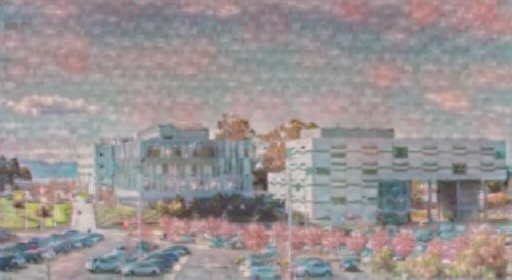

In [14]:
import tensorflow_hub as hub
hub_model_1 = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image1 = hub_model_1(tf.constant(content_image1), tf.constant(style_image1))[0]
tensor_to_image1(stylized_image1)

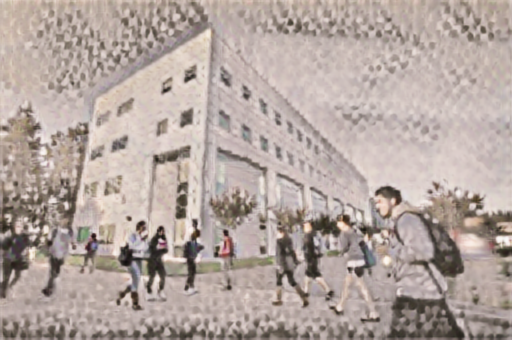

In [15]:
hub_model_2 = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image2 = hub_model_2(tf.constant(content_image2), tf.constant(style_image2))[0]
tensor_to_image1(stylized_image2)

# Define content and style representation

We are using the VGG19 as a feature extractor. This is an pre-trained CNN model. We will first pass our content image through our VGG19 network. The content image will go through the feed-forward process until it reaches a deep convolutional layer in the network. The output of this layer will be the content representation of the input image.

In [16]:
x = tf.keras.applications.vgg19.preprocess_input(content_image1*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape


TensorShape([1, 1000])

In [17]:
x = tf.keras.applications.vgg19.preprocess_input(content_image2*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [18]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('obelisk', 0.31247222),
 ('triumphal_arch', 0.14896436),
 ('bell_cote', 0.09479901),
 ('flagpole', 0.07189041),
 ('sundial', 0.0382116)]

Now load a VGG19 without the classification head, and list the layer names

In [19]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_3
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


Choose intermediate layers from the network to represent the style and content of the image

In [20]:
content_layers1 = ['block5_conv2'] 

style_layers1 = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers1 = len(content_layers1)
num_style_layers1 = len(style_layers1)

In [21]:
content_layers2 = ['block5_conv2'] 

style_layers2 = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers2 = len(content_layers2)
num_style_layers2 = len(style_layers2)

# Build the model

To define a model using the functional API, specify the inputs and outputs:

model = Model(inputs, outputs)

This following function builds a VGG19 model that returns a list of intermediate layer outputs:

In [22]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [25]:
style_extractor1 = vgg_layers(style_layers1)
style_outputs1 = style_extractor1(style_image1*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers1, style_outputs1):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 506, 512, 64)
  min:  0.0
  max:  814.4532
  mean:  25.954447

block2_conv1
  shape:  (1, 253, 256, 128)
  min:  0.0
  max:  2554.938
  mean:  133.06595

block3_conv1
  shape:  (1, 126, 128, 256)
  min:  0.0
  max:  8090.989
  mean:  114.57086

block4_conv1
  shape:  (1, 63, 64, 512)
  min:  0.0
  max:  12123.175
  mean:  462.43735

block5_conv1
  shape:  (1, 31, 32, 512)
  min:  0.0
  max:  2129.4258
  mean:  31.055548



In [26]:
style_extractor2 = vgg_layers(style_layers2)
style_outputs2 = style_extractor2(style_image2*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers2, style_outputs2):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 512, 512, 64)
  min:  0.0
  max:  852.4884
  mean:  33.732094

block2_conv1
  shape:  (1, 256, 256, 128)
  min:  0.0
  max:  3012.3748
  mean:  179.00308

block3_conv1
  shape:  (1, 128, 128, 256)
  min:  0.0
  max:  9174.078
  mean:  152.82521

block4_conv1
  shape:  (1, 64, 64, 512)
  min:  0.0
  max:  14814.93
  mean:  575.90955

block5_conv1
  shape:  (1, 32, 32, 512)
  min:  0.0
  max:  2554.9873
  mean:  39.30771



The correlations in each layer are given by a gram matrix. To calculate the style loss between a target and style image we find the mean squared distance between the style and target image gram matrices.

In [27]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

Build a model that returns the style and content tensors.

In [28]:
class StyleContentModel1(tf.keras.models.Model):
  def __init__(self, style_layers1, content_layers1):
    super(StyleContentModel1, self).__init__()
    self.vgg = vgg_layers(style_layers1 + content_layers1)
    self.style_layers1 = style_layers1
    self.content_layers1 = content_layers1
    self.num_style_layers1 = len(style_layers1)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs1, content_outputs1 = (outputs[:self.num_style_layers1],
                                      outputs[self.num_style_layers1:])

    style_outputs1 = [gram_matrix(style_output1)
                     for style_output1 in style_outputs1]

    content_dict1 = {content_name: value
                    for content_name, value
                    in zip(self.content_layers1, content_outputs1)}

    style_dict1 = {style_name: value
                  for style_name, value
                  in zip(self.style_layers1, style_outputs1)}

    return {'content': content_dict1, 'style': style_dict1}

In [34]:
class StyleContentModel2(tf.keras.models.Model):
  def __init__(self, style_layers2, content_layers2):
    super(StyleContentModel2, self).__init__()
    self.vgg = vgg_layers(style_layers2+ content_layers2)
    self.style_layers2 = style_layers2
    self.content_layers2 = content_layers2
    self.num_style_layers2 = len(style_layers2)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs2, content_outputs2 = (outputs[:self.num_style_layers2],
                                      outputs[self.num_style_layers2:])

    style_outputs2 = [gram_matrix(style_output2)
                     for style_output2 in style_outputs2]

    content_dict2 = {content_name: value
                    for content_name, value
                    in zip(self.content_layers2, content_outputs2)}

    style_dict2 = {style_name: value
                  for style_name, value
                  in zip(self.style_layers2, style_outputs2)}

    return {'content': content_dict2, 'style': style_dict2}

When called on an image, this model returns the gram matrix (style) of the style_layers and content of the content_layers:

In [35]:
extractor1 = StyleContentModel1(style_layers1, content_layers1)

results1 = extractor1(tf.constant(content_image1))

print('Styles:')
for name, output in sorted(results1['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results1['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.15682442
    max:  57264.18
    mean:  774.34607

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  164467.44
    mean:  21473.328

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  440160.62
    mean:  20256.805

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  5367246.5
    mean:  290062.03

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  127718.03
    mean:  2189.627

Contents:
   block5_conv2
    shape:  (1, 17, 32, 512)
    min:  0.0
    max:  1119.1691
    mean:  15.730705


In [36]:
extractor2 = StyleContentModel2(style_layers2, content_layers2)

results2 = extractor2(tf.constant(content_image2))

print('Styles:')
for name, output in sorted(results2['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results2['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.02921539
    max:  36354.13
    mean:  484.12726

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  74700.19
    mean:  12216.603

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  194858.22
    mean:  13821.968

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  3501470.8
    mean:  191234.78

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  142621.88
    mean:  2038.3378

Contents:
   block5_conv2
    shape:  (1, 21, 32, 512)
    min:  0.0
    max:  1832.9955
    mean:  17.024118


Implement the style transfer algorithm. Do this by calculating the mean square error for your image's output relative to each target, then take the weighted sum of these losses.

In [37]:
style_targets1 = extractor1(style_image1)['style']
content_targets1 = extractor1(content_image1)['content']

In [38]:
style_targets2 = extractor2(style_image2)['style']
content_targets2 = extractor2(content_image2)['content']

Defining a tf.Variable to contain the image to optimize. 

In [39]:
image1 = tf.Variable(content_image1)

In [40]:
image2 = tf.Variable(content_image2)

Since this is a float image, define a function to keep the pixel values between 0 and 1:

In [41]:
def clip_0_1(image1):
  return tf.clip_by_value(image1, clip_value_min=0.0, clip_value_max=1.0)

In [42]:
def clip_0_1(image2):
  return tf.clip_by_value(image2, clip_value_min=0.0, clip_value_max=1.0)

Create an optimizer: Adam

In [43]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

To optimize this, use a weighted combination of the two losses to get the total loss:

In [1]:
style_weight=1e-2
content_weight=1e4

In [45]:
def style_content_loss1(outputs1):
    style_outputs1 = outputs1['style']
    content_outputs1 = outputs1['content']
    style_loss1 = tf.add_n([tf.reduce_mean((style_outputs1[name]-style_targets1[name])**2) 
                           for name in style_outputs1.keys()])
    style_loss1 *= style_weight / num_style_layers1

    content_loss1 = tf.add_n([tf.reduce_mean((content_outputs1[name]-content_targets1[name])**2) 
                             for name in content_outputs1.keys()])
    content_loss1 *= content_weight / num_content_layers1
    loss1 = style_loss1 + content_loss1
    return loss1

In [46]:
def style_content_loss2(outputs2):
    style_outputs2 = outputs2['style']
    content_outputs2 = outputs2['content']
    style_loss2 = tf.add_n([tf.reduce_mean((style_outputs2[name]-style_targets2[name])**2) 
                           for name in style_outputs2.keys()])
    style_loss2 *= style_weight / num_style_layers2

    content_loss2 = tf.add_n([tf.reduce_mean((content_outputs2[name]-content_targets2[name])**2) 
                             for name in content_outputs2.keys()])
    content_loss2 *= content_weight / num_content_layers2
    loss2 = style_loss2 + content_loss2
    return loss2

Use tf.GradientTape to update the image.

In [47]:
@tf.function()
def train_step1(image1):
  with tf.GradientTape() as tape:
    outputs1 = extractor1(image1)
    loss1 = style_content_loss1(outputs1)

  grad1 = tape.gradient(loss1, image1)
  opt.apply_gradients([(grad1, image1)])
  image1.assign(clip_0_1(image1))

In [48]:
@tf.function()
def train_step2(image2):
  with tf.GradientTape() as tape:
    outputs2 = extractor1(image2)
    loss2 = style_content_loss2(outputs2)

  grad2 = tape.gradient(loss2, image2)
  opt.apply_gradients([(grad2, image2)])
  image2.assign(clip_0_1(image2))

Run a few steps to test

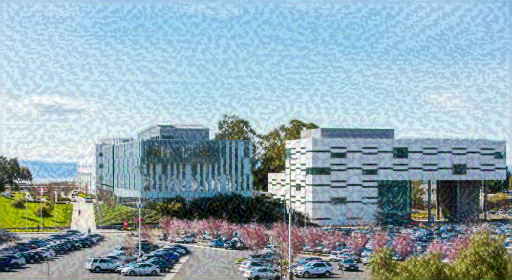

In [50]:
train_step1(image1)
train_step1(image1)
train_step1(image1)
tensor_to_image1(image1)

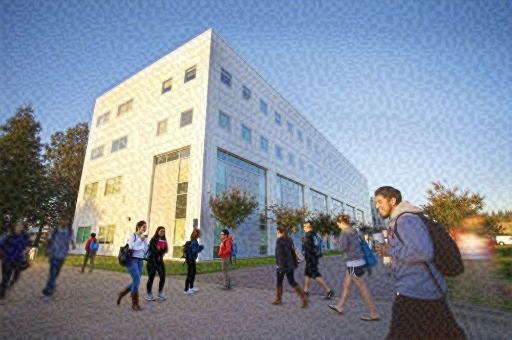

In [51]:
train_step2(image2)
train_step2(image2)
train_step2(image2)
tensor_to_image2(image2)

Since it's working, perform a longer optimization:

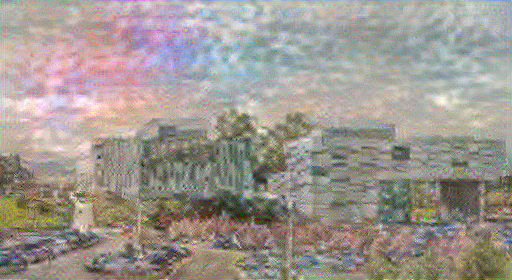

Train step: 1000
Total time: 1498.5


In [54]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step1(image1)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image1(image1))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

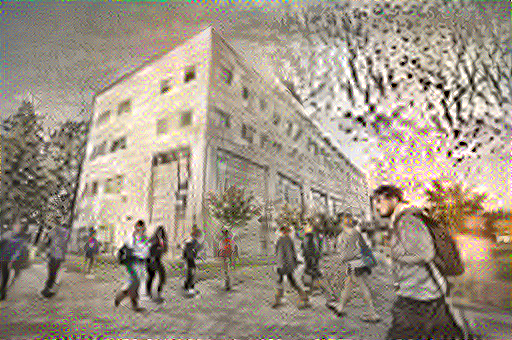

Train step: 1000
Total time: 1789.0


In [55]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step2(image2)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image2(image2))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

The model produces a lot of high frequency artifacts. We are going to decrease these using regularization term on the high frequency components of the image.
Total variation loss:

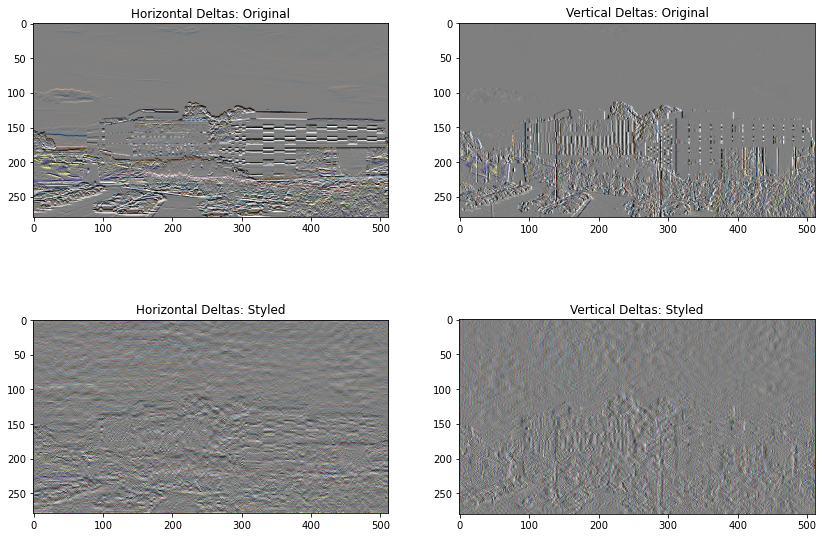

In [57]:
def high_pass_x_y1(image1):
  x_var1 = image1[:, :, 1:, :] - image1[:, :, :-1, :]
  y_var1 = image1[:, 1:, :, :] - image1[:, :-1, :, :]

  return x_var1, y_var1

x_deltas1, y_deltas1 = high_pass_x_y1(content_image1)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas1+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas1+0.5), "Vertical Deltas: Original")

x_deltas1, y_deltas1 = high_pass_x_y1(image1)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas1+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas1+0.5), "Vertical Deltas: Styled")

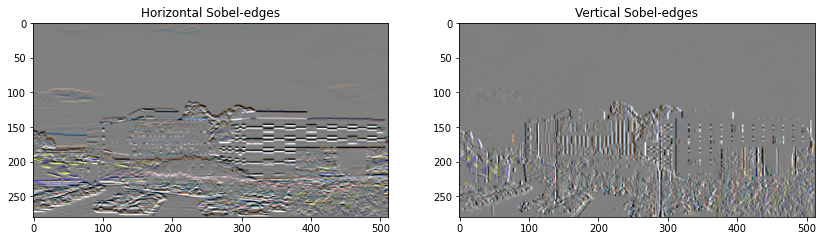

In [58]:
plt.figure(figsize=(14, 10))

sobel1 = tf.image.sobel_edges(content_image1)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel1[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel1[..., 1]/4+0.5), "Vertical Sobel-edges")

In [59]:
def total_variation_loss1(image1):
  x_deltas1, y_deltas1 = high_pass_x_y1(image1)
  return tf.reduce_sum(tf.abs(x_deltas1)) + tf.reduce_sum(tf.abs(y_deltas1))

total_variation_loss1(image1).numpy()

62046.836

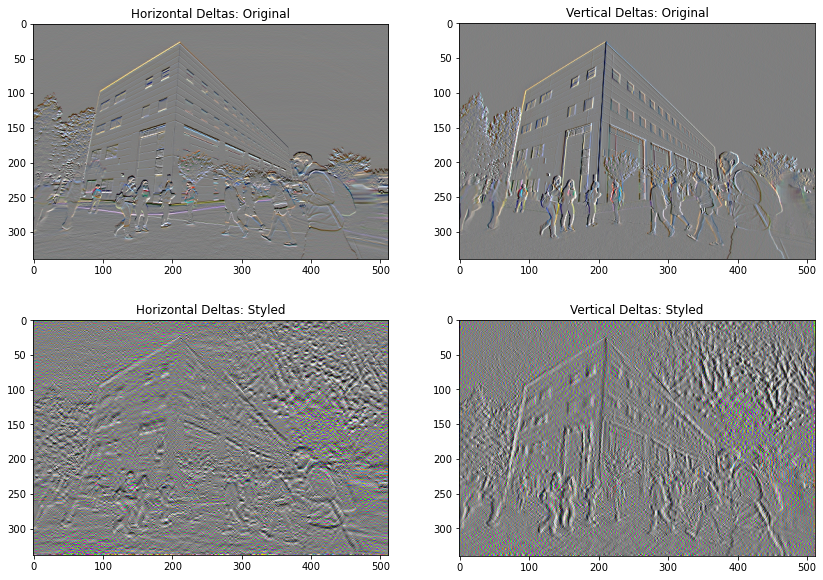

In [60]:
def high_pass_x_y2(image2):
  x_var2 = image2[:, :, 1:, :] - image2[:, :, :-1, :]
  y_var2 = image2[:, 1:, :, :] - image2[:, :-1, :, :]

  return x_var2, y_var2

x_deltas2, y_deltas2 = high_pass_x_y2(content_image2)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas2+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas2+0.5), "Vertical Deltas: Original")

x_deltas2, y_deltas2 = high_pass_x_y2(image2)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas2+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas2+0.5), "Vertical Deltas: Styled")

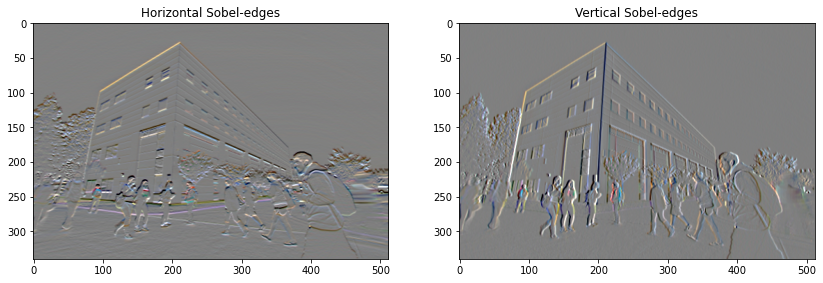

In [61]:
plt.figure(figsize=(14, 10))

sobel2 = tf.image.sobel_edges(content_image2)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel2[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel2[..., 1]/4+0.5), "Vertical Sobel-edges")

In [62]:
def total_variation_loss2(image2):
  x_deltas2, y_deltas2 = high_pass_x_y2(image2)
  return tf.reduce_sum(tf.abs(x_deltas2)) + tf.reduce_sum(tf.abs(y_deltas2))

total_variation_loss2(image2).numpy()

91396.95

In [63]:
tf.image.total_variation(image1).numpy()

array([62046.836], dtype=float32)

In [64]:
tf.image.total_variation(image2).numpy()

array([91396.95], dtype=float32)

Re-run the optimization
Choose a weight for the total_variation_loss:

In [65]:
total_variation_weight=30

Now include it in the train_step function:

In [86]:
@tf.function()
def train_step1(image1):
  with tf.GradientTape() as tape:
    outputs1 = extractor1(image1)
    loss1 = style_content_loss1(outputs1)
    loss1 += total_variation_weight*tf.image.total_variation(image1)

  grad1 = tape.gradient(loss1, image1)
  opt.apply_gradients([(grad1, image1)])
  image1.assign(clip_0_1(image1))

In [87]:
@tf.function()
def train_step2(image2):
  with tf.GradientTape() as tape:
    outputs2 = extractor2(image2)
    loss2 = style_content_loss2(outputs2)
    loss2 += total_variation_weight*tf.image.total_variation(image2)

  grad2 = tape.gradient(loss2, image2)
  opt.apply_gradients([(grad2, image2)])
  image2.assign(clip_0_1(image2))

Reinitialize the optimization variable:

In [88]:
image1 = tf.Variable(content_image1)

In [89]:
image2 = tf.Variable(content_image2)

And run the optimization

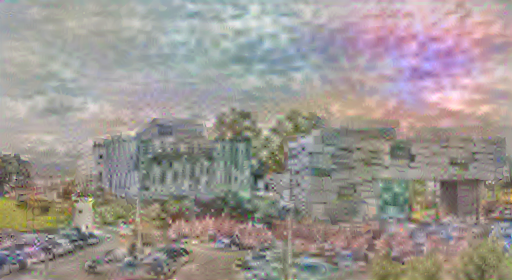

Train step: 1000
Total time: 1479.6


In [90]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step1(image1)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image1(image1))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

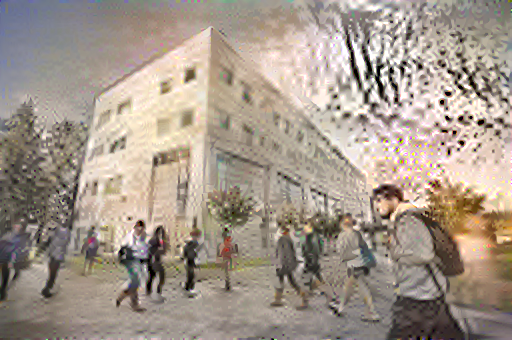

Train step: 1000
Total time: 1781.3


In [94]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step2(image2)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image2(image2))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

Save the result

In [92]:
file_name1 = 'stylized-image1.png'
tensor_to_image1(image1).save(file_name1)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

In [93]:
file_name2 = 'stylized-image2.png'
tensor_to_image2(image2).save(file_name2)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)